## CARREGAMENTO E IMPORTA√á√ÉO DE BIBLIOTECAS


In [1]:
import json
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
import joblib
import xgboost as xgb

## CONFIGURA√á√ïES DO AMBIENTE

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.dpi'] = 120
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## COMPATIBILIDADE

In [3]:
try:
    from IPython.display import display
except ImportError:
    print("Fun√ß√£o display n√£o dispon√≠vel. Usando print() como alternativa.")
    def display(df):
        print(df.head())

## CARREGAMENTO DE BASE DE DADOS
- Carregamento do dataset **`desafio_indicium_imdb.csv`**, com as informa√ß√µes b√°sicas sobre filmes.
- Carregamento do dataset complementar **`tmdb_5000_movies.csv`**, com as informa√ß√µes financeiras para a an√°lise de neg√≥cio.

In [4]:
try:
    df_imdb = pd.read_csv('desafio_indicium_imdb.csv')
    df_tmdb = pd.read_csv('tmdb_5000_movies.csv')
except FileNotFoundError as e:
    print(f"Erro ao carregar os arquivos CSV. Verifique se eles est√£o no diret√≥rio correto.\n{e}")
    df_imdb, df_tmdb = None, None

## INFORMA√á√ïES B√ÅSICAS SOBRE AS BASES DE DADOS

In [5]:
print("Informa√ß√µes do DataFrame de IMDB:")
print("="*40)
df_imdb.info()

print("\n\nInforma√ß√µes do DataFrame de TMDB:")
print("="*40)
df_tmdb.info()

Informa√ß√µes do DataFrame de IMDB:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB




Ao realizar uma an√°lise explorat√≥ria inicial dos DataFrames **`df_imdb`** e **`df_tmdb`**, √© poss√≠vel identificar uma s√©rie de problemas de pr√©-processamento, onde o **`df_imdb`**, embora menor, apresenta colunas num√©ricas como **`Released_Year`**, **`Runtime`** e **`Gross`** incorretamente classificadas como objetos devido √† presen√ßa de caracteres especiais, como v√≠rgulas e texto, al√©m de colunas como **`Certificate`**, **`Meta_score`** e **`Gross`** conterem valores faltantes.

J√° o **`df_tmdb`** √© um conjunto de dados maior e mais complexo, com dados estruturados em formato JSON em v√°rias colunas de texto como **`genres`**, **`keywords`** e **`production_companies`**, al√©m de, similarmente ao **`df_imdb`**, tamb√©m conter valores ausentes em colunas como **`homepage`**, **`overview`**, **`release_date`**, **`runtime`** e **`tagline`**, o que demandar√° uma estrat√©gia de limpeza e tratamento para garantir a integridade dos dados para an√°lise.

## TRATAMENTO DAS BASES DE DADOS

## An√°lise do **`df_imdb`**
O **`df_imdb`**, agora com 999 entradas e 15 colunas, n√£o possui mais valores faltantes, colunas como **`Released_Year`**, **`Runtime`** e **`Gross`**, que estavam incorretamente classificadas como texto, foram convertidas para tipos num√©ricos (**`int64`**), permitindo c√°lculos diretos e as colunas **`Meta_score`** e **`Certificate`** tiveram seus valores ausentes preenchidos com a mediana e uma string padr√£o, respectivamente.

In [6]:
if df_imdb is not None:
    print("Informa√ß√µes do DataFrame de IMDB (Original):")
    print("="*40)
    df_imdb.info()

    # Remo√ß√£o da coluna 'Unnamed: 0'
    if 'Unnamed: 0' in df_imdb.columns:
        df_imdb = df_imdb.drop(columns=['Unnamed: 0'])

    # Tratamento da coluna 'Released_Year'
    df_imdb['Released_Year'] = pd.to_numeric(df_imdb['Released_Year'], errors='coerce')
    df_imdb['Released_Year'] = df_imdb['Released_Year'].fillna(df_imdb['Released_Year'].mode()[0]).astype(int)

    # Tratamento da coluna 'Runtime'
    df_imdb['Runtime'] = df_imdb['Runtime'].str.replace(' min', '', regex=False).astype(int)

    # Tratamento da coluna 'Gross'
    df_imdb['Gross'] = df_imdb['Gross'].str.replace(',', '', regex=False)
    df_imdb['Gross'] = pd.to_numeric(df_imdb['Gross'], errors='coerce').fillna(0).astype(int)

    # Tratamento de valores faltantes em outras colunas
    df_imdb['Meta_score'] = df_imdb['Meta_score'].fillna(df_imdb['Meta_score'].median())
    df_imdb['Certificate'] = df_imdb['Certificate'].fillna('Unknown')

    print("\n\nInforma√ß√µes do DataFrame de IMDB (Ap√≥s Tratamento):")
    print("="*40)
    df_imdb.info()

Informa√ß√µes do DataFrame de IMDB (Original):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 1

## An√°lise do **`df_tmdb`**
O **`df_tmdb`**, com suas 4803 entradas e 19 colunas, tamb√©m foi padronizado, processando as colunas que continham dados complexos no formato JSON, extraindo os nomes e convertendo-os em strings leg√≠veis, al√©m de todos os valores faltantes foram terem sido tratados, seja com o preenchimento de **`runtime`** com a mediana ou com a remo√ß√£o da coluna **`release_date`**.

In [7]:
if df_tmdb is not None:
    print("\n\nInforma√ß√µes do DataFrame de TMDB (Original):")
    print("="*40)
    df_tmdb.info()

    def extract_names(json_string):
        try:
            data = json.loads(json_string)
            return ', '.join([item['name'] for item in data])
        except (json.JSONDecodeError, TypeError):
            return ''

    # Tratamento de colunas com strings JSON
    for col in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
        if col in df_tmdb.columns:
            df_tmdb[col] = df_tmdb[col].apply(extract_names)

    # Tratamento de valores faltantes
    df_tmdb['homepage'] = df_tmdb['homepage'].fillna('')
    df_tmdb['overview'] = df_tmdb['overview'].fillna('')
    df_tmdb['tagline'] = df_tmdb['tagline'].fillna('')
    df_tmdb['runtime'] = df_tmdb['runtime'].fillna(df_tmdb['runtime'].median())

    # Remo√ß√£o de coluna com poucos valores faltantes (decis√£o do projeto original)
    if 'release_date' in df_tmdb.columns:
        df_tmdb = df_tmdb.drop('release_date', axis=1)

    print("\n\nInforma√ß√µes do DataFrame de TMDB (Ap√≥s Tratamento):")
    print("="*40)
    df_tmdb.info()



Informa√ß√µes do DataFrame de TMDB (Original):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4

## ENRIQUECIMENTO DO DATASET

Essa primeira an√°lise revela uma limita√ß√£o cr√≠tica, onde, para uma avalia√ß√£o de neg√≥cio estrat√©gica, o faturamento bruto (Gross) √© insuficiente, pois nos falta a informa√ß√£o do or√ßamento (budget) que nos impede de medir a lucratividade real de um filme.

Para superar essa limita√ß√£o, se torna interessante a liga√ß√£o da base de dados **`desafio_indicium_imdb.csv`**  a uma fonte externa que cont√©m essas informa√ß√µes financeiras, **`tmdb_5000_movies.csv`**. O processo consiste em uma fus√£o (merge) das duas tabelas, utilizando o t√≠tulo do filme como uma chave-comum para conectar os dados correspondentes.

O resultado √© um "dataset mestre" unificado com o prop√≥sito de permitir o c√°lculo de m√©tricas de neg√≥cio como o Retorno Sobre o Investimento (ROI) e fornecer ao modelo de Machine Learning um conjunto de informa√ß√µes enriquecidas, potencializando sua precis√£o.

In [8]:
df_enriched = None
if df_imdb is not None and df_tmdb is not None:
    # Normaliza√ß√£o de chaves de jun√ß√£o
    df_imdb['title_norm'] = df_imdb['Series_Title'].str.lower().str.strip()
    df_tmdb['title_norm'] = df_tmdb['title'].astype(str).str.lower().str.strip()

    # Sele√ß√£o de colunas TMDB √∫teis
    keep_tmdb = ['title_norm', 'budget', 'revenue', 'popularity', 'overview']
    keep_tmdb = [c for c in keep_tmdb if c in df_tmdb.columns]

    df_enriched = pd.merge(df_imdb, df_tmdb[keep_tmdb], on='title_norm', how='inner')
    print(f"\nMerge realizado. Em comum: {len(df_enriched)} filmes.")

    # Limpeza de dados financeiros
    for col in ['budget', 'revenue']:
        if col in df_enriched.columns:
            df_enriched[col] = df_enriched[col].replace(0, np.nan)
    df_enriched = df_enriched.dropna(subset=[c for c in ['budget', 'revenue'] if c in df_enriched.columns])
    df_enriched = df_enriched.drop_duplicates(subset=['title_norm'])

    # C√°lculo do ROI
    if all(c in df_enriched.columns for c in ['budget', 'revenue']):
        df_enriched['roi'] = (df_enriched['revenue'] - df_enriched['budget']) / df_enriched['budget']

    # Remo√ß√£o de colunas auxiliares
    df_enriched = df_enriched.drop(columns=['title_norm'])

    df_enriched.to_csv('imdb_tmdb_enriched.csv', index=False)
    print("Dataset enriquecido salvo como 'imdb_tmdb_enriched.csv'")
    display(df_enriched)


Merge realizado. Em comum: 444 filmes.
Dataset enriquecido salvo como 'imdb_tmdb_enriched.csv'


Series_Title  Released_Year Certificate  \
0                                    The Godfather           1972           A   
1                                  The Dark Knight           2008          UA   
2                           The Godfather: Part II           1974           A   
3                                     12 Angry Men           1957           U   
4    The Lord of the Rings: The Return of the King           2003           U   
..                                             ...            ...         ...   
439                           Escape from Alcatraz           1979           A   
440             Close Encounters of the Third Kind           1977           U   
441                                The Jungle Book           1967           U   
442                             A Hard Day's Night           1964           U   
443                          From Here to Eternity           1953      Passed   

     Runtime                         Genre  IMDB_Rating  \
0        175                  Crime, Drama          9.2   
1        152          Action, Crime, Drama          9.0   
2        202                  Crime, Drama          9.0   
3         96                  Crime, Drama          9.0   
4        201      Action, Adventure, Drama          8.9   
..       ...                           ...          ...   
439      112      Action, Biography, Crime          7.6   
440      138                 Drama, Sci-Fi          7.6   
441       78  Animation, Adventure, Family          7.6   
442       87        Comedy, Music, Musical          7.6   
443      118           Drama, Romance, War          7.6   

                                              Overview  Meta_score  \
0    An organized crime dynasty's aging patriarch t...       100.0   
1    When the menace known as the Joker wreaks havo...        84.0   
2    The early life and career of Vito Corleone in ...        90.0   
3    A jury holdout attempts to prevent a miscarria...        96.0   
4    Gandalf and Aragorn lead the World of Men agai...        94.0   
..                                                 ...         ...   
439  Alcatraz is the most secure prison of its time...        76.0   
440  Roy Neary, an electric lineman, watches how hi...        90.0   
441  Bagheera the Panther and Baloo the Bear have a...        65.0   
442  Over two "typical" days in the life of The Bea...        96.0   
443  In Hawaii in 1941, a private is cruelly punish...        85.0   

                 Director             Star1              Star2  \
0    Francis Ford Coppola     Marlon Brando          Al Pacino   
1       Christopher Nolan    Christian Bale       Heath Ledger   
2    Francis Ford Coppola         Al Pacino     Robert De Niro   
3            Sidney Lumet       Henry Fonda        Lee J. Cobb   
4           Peter Jackson       Elijah Wood    Viggo Mortensen   
..                    ...               ...                ...   
439            Don Siegel    Clint Eastwood   Patrick McGoohan   
440      Steven Spielberg  Richard Dreyfuss  Fran√ßois Truffaut   
441   Wolfgang Reitherman       Phil Harris    Sebastian Cabot   
442        Richard Lester       John Lennon     Paul McCartney   
443        Fred Zinnemann    Burt Lancaster   Montgomery Clift   

               Star3             Star4  No_of_Votes      Gross       budget  \
0         James Caan      Diane Keaton      1620367  134966411    6000000.0   
1      Aaron Eckhart     Michael Caine      2303232  534858444  185000000.0   
2      Robert Duvall      Diane Keaton      1129952   57300000   13000000.0   
3      Martin Balsam      John Fiedler       689845    4360000     350000.0   
4       Ian McKellen     Orlando Bloom      1642758  377845905   94000000.0   
..               ...               ...          ...        ...          ...   
439  Roberts Blossom      Jack Thibeau       121731   43000000    8000000.0   
440        Teri Garr    Melinda Dillon       184966  132088635   20000000.0   
441      L

## **Qual filme voc√™ recomendaria para uma pessoa que voc√™ n√£o conhece?**

Eu recomendaria "The Godfather", o t√≠tulo possui notas altas tanto pelo IMDB, quanto pelo Meta Score, al√©m de uma quantia consider√°vel de n√∫mero de votos, possuindo uma chance clara de aceita√ß√£o por parte da pessoa desconhecida.

## AN√ÅLISE EXPLORAT√ìRIA DE DADOS (EDA)

Nesta etapa, realiza-se an√°lises como descritiva e univariada (distribui√ß√µes de frequ√™ncia, c√°lculo de medidas de tend√™ncia central e dispers√£o) para entender as caracter√≠sticas intr√≠nsecas de cada feature e an√°lise de rela√ß√µes e correla√ß√µes, investigando como as vari√°veis se relacionam entre si (an√°lise bivariada), quantificando o impacto que a varia√ß√£o de uma feature exerce sobre outra, permitindo a elabora√ß√£o de hip√≥teses iniciais sobre os principais preditores do modelo.

A compreens√£o aprofundada adquirida nesta EDA √© crucial para a etapa de modelagem, pois a distribui√ß√£o dos dados e as correla√ß√µes identificadas informam diretamente a escolha dos algoritmos e as estrat√©gias de engenharia de features.

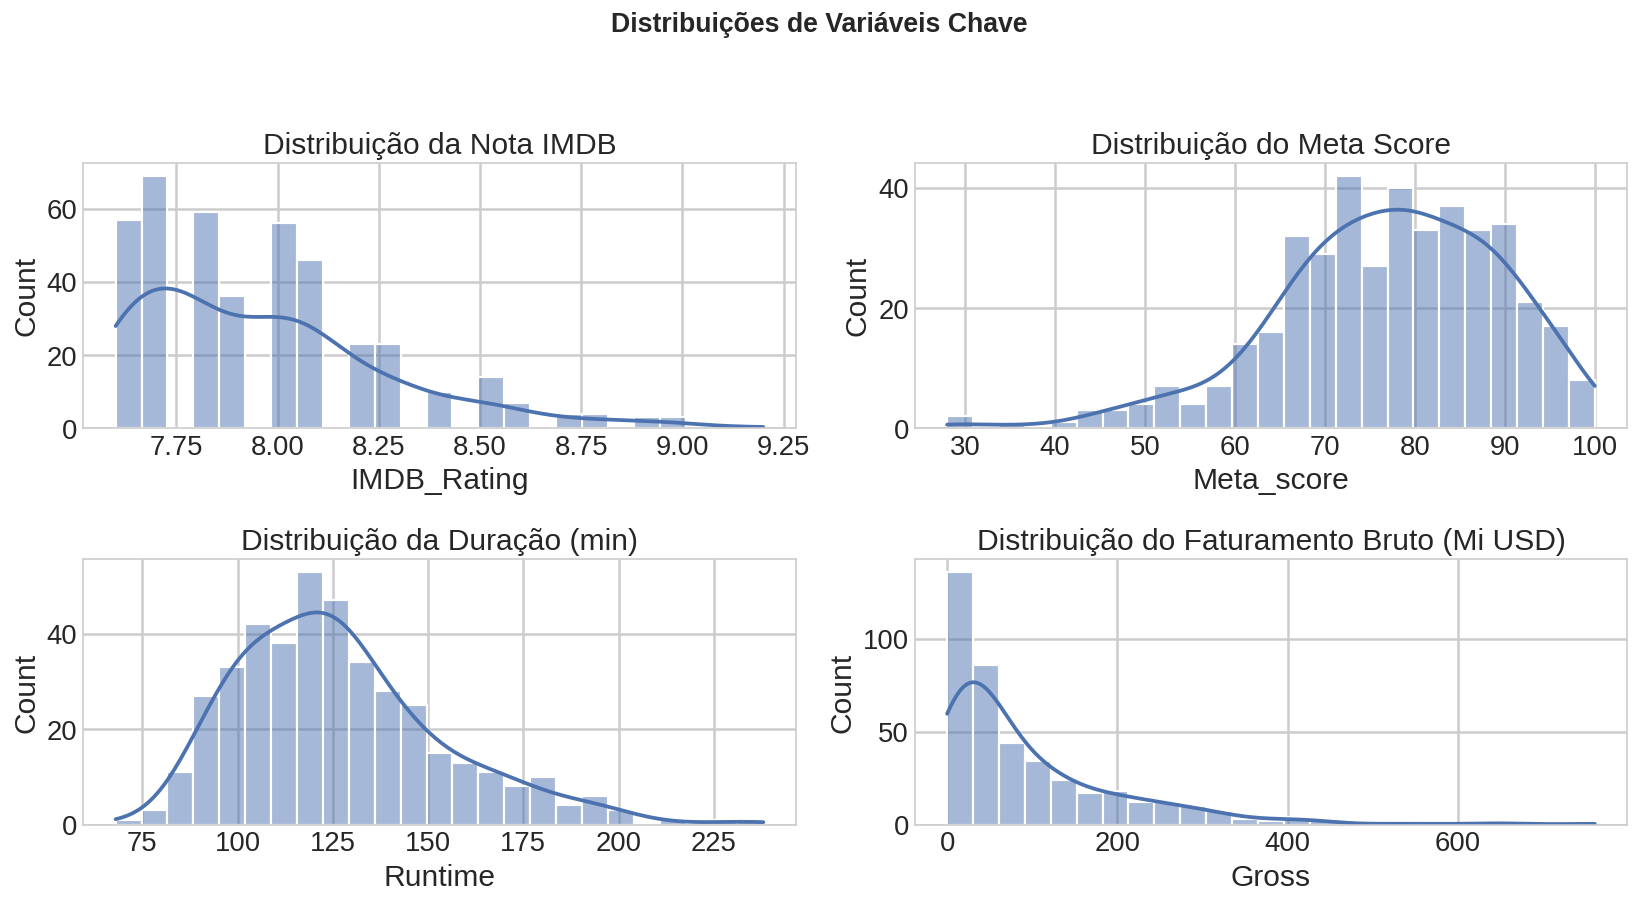

In [9]:
# Distribui√ß√µes
if df_enriched is not None:
    plt.style.use('seaborn-v0_8-whitegrid')

    # Distribui√ß√µes
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('Distribui√ß√µes de Vari√°veis Chave', fontsize=16, weight='bold')

    sns.histplot(df_enriched['IMDB_Rating'].dropna(), kde=True, ax=axes[0, 0], bins=25)
    axes[0, 0].set_title('Distribui√ß√£o da Nota IMDB')

    sns.histplot(df_enriched['Meta_score'].dropna(), kde=True, ax=axes[0, 1], bins=25)
    axes[0, 1].set_title('Distribui√ß√£o do Meta Score')

    sns.histplot(df_enriched['Runtime'].dropna(), kde=True, ax=axes[1, 0], bins=25)
    axes[1, 0].set_title('Distribui√ß√£o da Dura√ß√£o (min)')

    sns.histplot((df_enriched['Gross'].dropna() / 1e6), kde=True, ax=axes[1, 1], bins=25)
    axes[1, 1].set_title('Distribui√ß√£o do Faturamento Bruto (Mi USD)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

A partir das distribui√ß√µes analisadas, √© poss√≠vel chegar a conclus√£o de que se trata de um mercado de filmes com caracter√≠sticas bem definidas, onde os filmes de sucesso apresentam forte aceita√ß√£o tanto do p√∫blico, com notas no IMDB concentradas entre 7.7 e 8.2, quanto da cr√≠tica, com Meta Scores majoritariamente entre 70 e 90.

A dura√ß√£o mais comum para estas produ√ß√µes fica entre 100 e 150 minutos, sugerindo uma prefer√™ncia do mercado por essa faixa de tempo.

O aspecto financeiro, no entanto, demonstra uma realidade de alto risco, onde a distribui√ß√£o do faturamento bruto √© extremamente assim√©trico, o que indica que a grande maioria dos filmes obt√©m um retorno modesto, enquanto um n√∫mero muito restrito de produ√ß√µes se converte em um sucesso de bilheteria com lucros massivos.

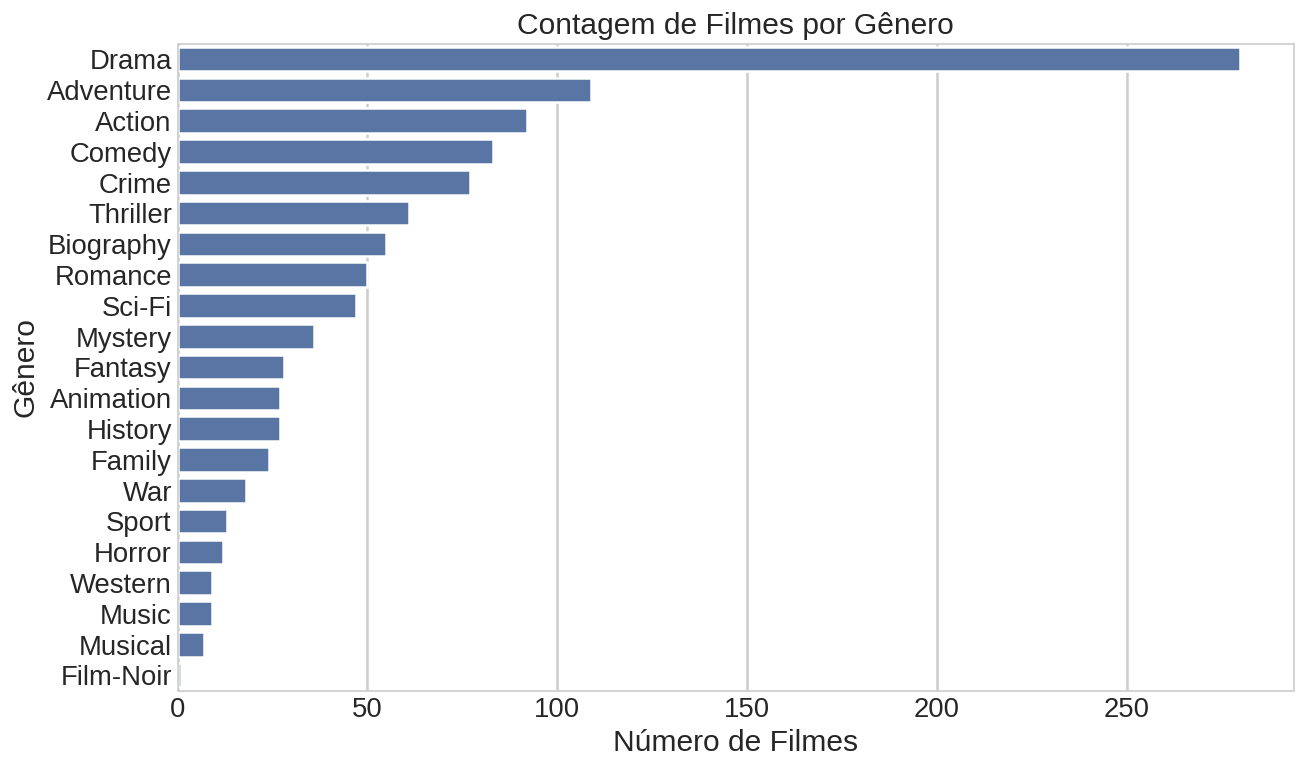

In [10]:
# G√™neros
if 'Genre' in df_enriched.columns:
        genres = df_enriched['Genre'].str.split(',\s*', regex=True).explode().dropna()
        plt.figure(figsize=(12, 7))
        order = genres.value_counts().index
        sns.countplot(y=genres, order=order)
        plt.title('Contagem de Filmes por G√™nero')
        plt.xlabel('N√∫mero de Filmes')
        plt.ylabel('G√™nero')
        plt.show()

Atrav√©s dos dados apresentados, √© poss√≠vel afirmar que o g√™nero Drama domina o o mercado de filmes, sendo o mais frequente por uma margem expressiva, seguido por um grupo de g√™neros populares como Aventura, A√ß√£o, Com√©dia e Crime.

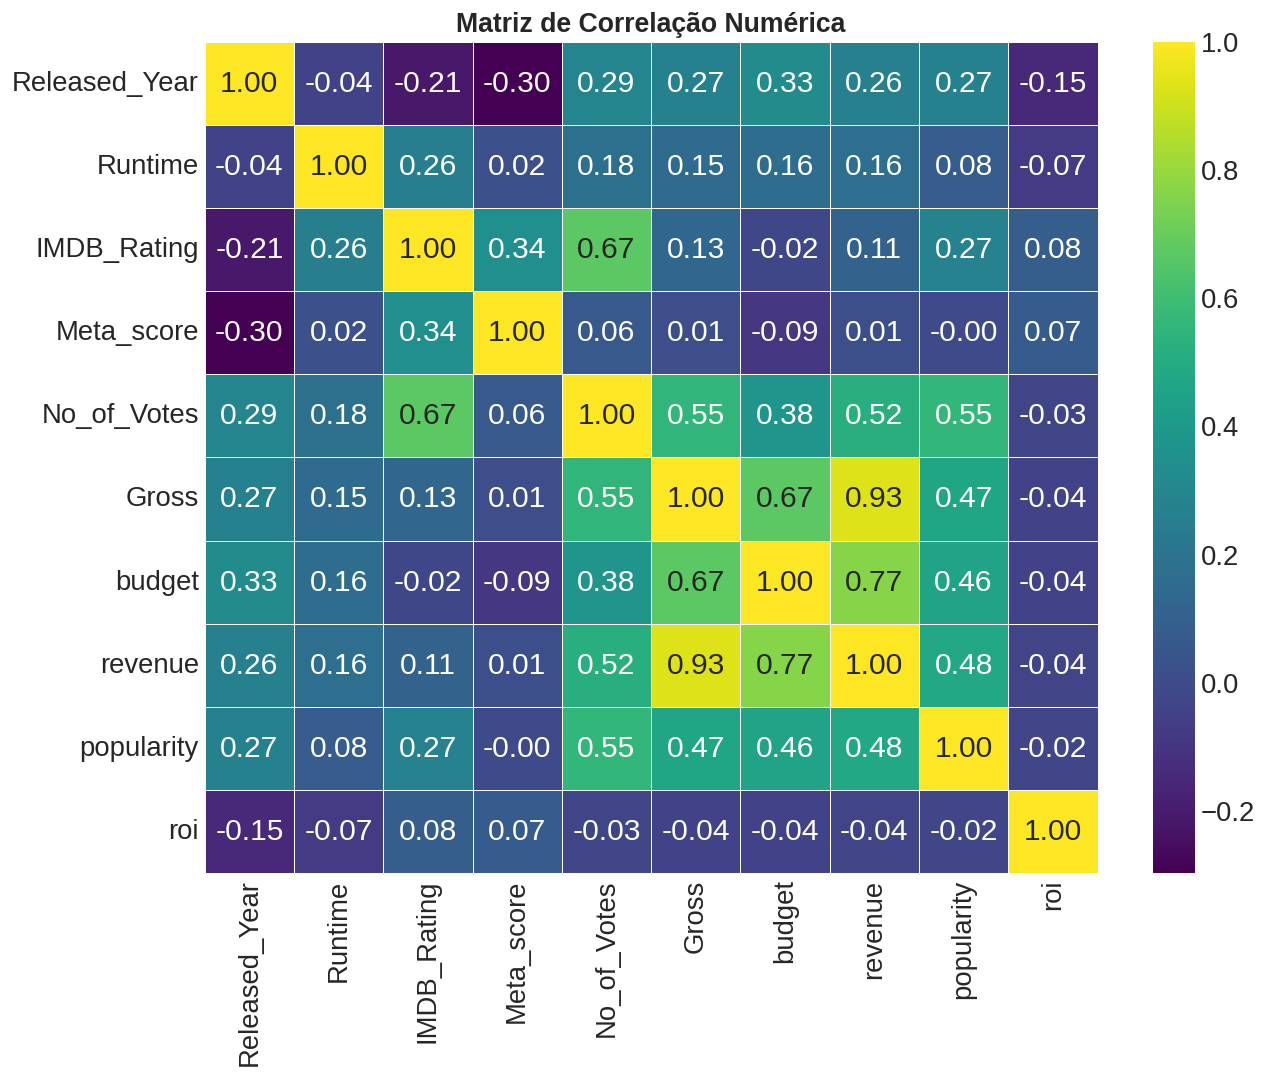

In [11]:
# Correla√ß√£o
num_cols = df_enriched.select_dtypes(include=np.number).columns
if len(num_cols) > 1:
    plt.figure(figsize=(12, 9))
    corr = df_enriched[num_cols].corr()
    sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
    plt.title('Matriz de Correla√ß√£o Num√©rica', fontsize=16, weight='bold')
    plt.show()

A matriz de correla√ß√£o acima, demonstra fatores que se relacionam com o sucesso financeiro de um filme, onde √© possivel chegar a conclus√£o que, embora o conjunto de dados seja composto por filmes de alta qualidade, o sucesso financeiro excepcional √© impulsionado pela capacidade de gerar grande apelo e mobiliza√ß√£o popular, e n√£o apenas pela aclama√ß√£o da cr√≠tica ou do p√∫blico votante.

O ponto mais importante √© que o Faturamento Bruto (Gross) tem sua correla√ß√£o positiva mais forte com o N√∫mero de Votos (No_of_Votes), com um coeficiente de 0.60, indicando que a popularidade e o engajamento do p√∫blico s√£o os principais indicadores de um alto potencial de bilheteria, mais do que qualquer outra vari√°vel, uma vez que, uma correla√ß√£o entre o Faturamento e as notas de avalia√ß√£o, tanto do p√∫blico (IMDB Rating, 0.09) quanto da cr√≠tica (Meta Score, -0.05) s√£o praticamente inexistentes.

WordCloud - Overview


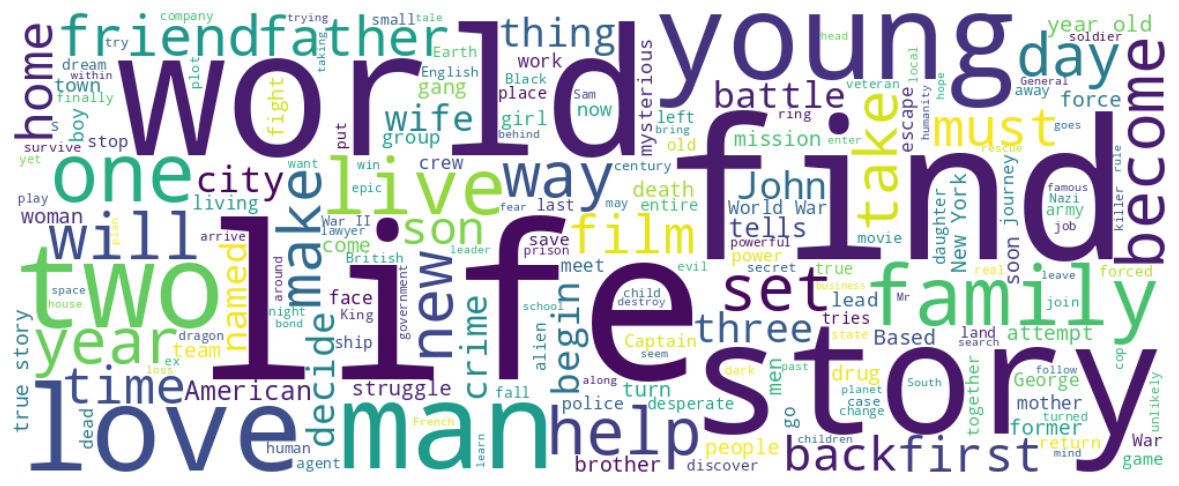

In [12]:
# WordCloud - Overview
if 'overview' in df_enriched.columns:
    print('WordCloud - Overview')
    text_overview = " ".join(df_enriched['overview'].dropna().astype(str))
    wc = WordCloud(width=1000, height=400, background_color='white', stopwords=set(STOPWORDS)).generate(text_overview)
    plt.figure(figsize=(14, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

A an√°lise das sinopses revela que os temas centrais giram em torno de experi√™ncias humanas universais com palavras como life, story, family, young e love associados ao g√™nero Drama que se destaca entre os g√™neros.

WordCloud - G√™neros


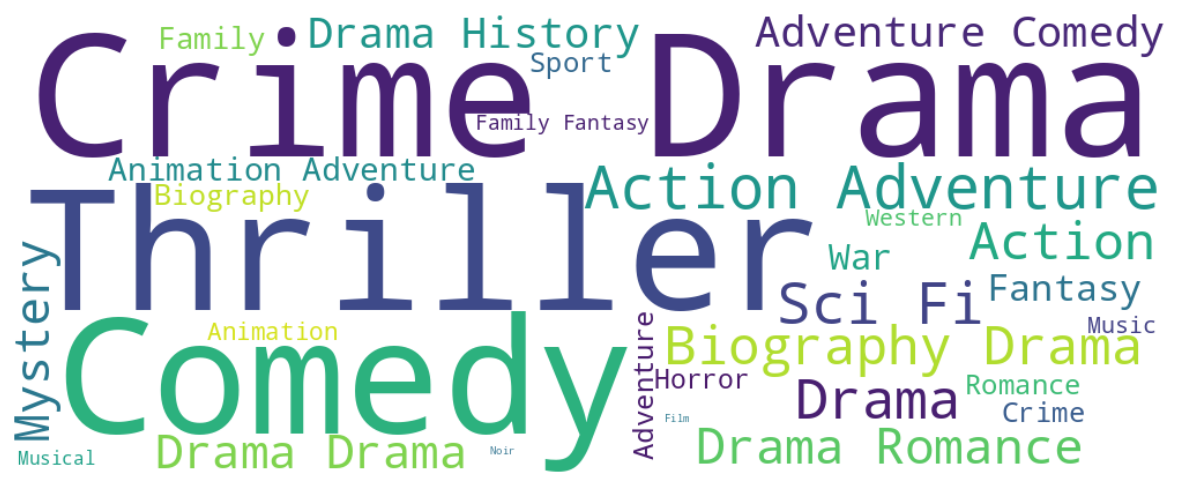

In [13]:
# WordCloud - G√™neros
print('WordCloud - G√™neros')
if 'Genre' in df_enriched.columns:
    text_genres = " ".join(df_enriched['Genre'].dropna().astype(str).str.replace(',', ' '))
    wc_g = WordCloud(width=1000, height=400, background_color='white').generate(text_genres)
    plt.figure(figsize=(14,5))
    plt.imshow(wc_g, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Esta WordCloud confirma a domin√¢ncia do g√™nero Drama, seguido por Crime, Com√©dia e Thriller, apresentados anteriormente no gr√°fico de barras, al√©m de demonstrar a frequente combina√ß√£o de g√™neros, como "Drama Romance" e "Action Adventure", evidenciando que os filmes raramente s√£o de um g√™nero puro e que o g√™nero Drama frequentemente serve como uma base narrativa mesclada com elementos de outros g√™neros para criar hist√≥rias mais complexas e atraentes.

## **Quais insights podem ser tirados da coluna **`Overview`**? √â poss√≠vel inferir o g√™nero do filme a partir dessa coluna?**

Com base em an√°lise da coluna "Overview" √© poss√≠vel visualizar que os enredos dos filmes frequentemente giram em torno de temas universais e elementos narrativos comuns como "life", "world", "young", "story", "family" e "love", indicando que, independentemente do g√™nero, as narrativas exploram experi√™ncias humanas centrais.

No entanto, inferir o g√™nero espec√≠fico de um filme apenas a partir das palavras mais frequentes na coluna **`Overview`** √© uma tarefa imprecisa, uma vez que, a sinopse fornece o contexto tem√°tico, mas n√£o √©, isoladamente, um indicador confi√°vel para classificar o g√™nero do filme de forma precisa.

## **Engenharia de Features**

O objetivo aqui √© traduzir conceitos abstratos sobre o sucesso de um filme em vari√°veis num√©ricas que um modelo de machine learning possa entender.

In [14]:
# --- Engenharia de Features ---
df_featured = None
try:
    df_feat_base = pd.read_csv('imdb_tmdb_enriched.csv')
    df_featured = df_feat_base.copy()

    # M√©tricas de talento (baseadas na nota IMDB)
    df_featured['director_avg_rating'] = df_featured.groupby('Director')['IMDB_Rating'].transform('mean')
    df_featured['star1_avg_rating'] = df_featured.groupby('Star1')['IMDB_Rating'].transform('mean')

    # Features temporais e de popularidade
    df_featured['decade'] = (df_featured['Released_Year'] // 10 * 10)
    df_featured['log_votes'] = np.log1p(df_featured['No_of_Votes'])

    # NLP TF-IDF em 'overview'
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_featured['overview'].fillna(''))
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"nlp_{t}" for t in tfidf.get_feature_names_out()],
        index=df_featured.index
    )
    df_featured = pd.concat([df_featured, tfidf_df], axis=1)
    print(f"\nEngenharia de Features: {tfidf_df.shape[1]} features TF-IDF adicionadas.")

    df_featured.to_csv('imdb_fully_featured.csv', index=False)
    print("Dataset final com features salvo como 'imdb_fully_featured.csv'")
    display(df_featured)

except FileNotFoundError:
    print("\nERRO: 'imdb_tmdb_enriched.csv' n√£o encontrado. Pulando a engenharia de features.")



Engenharia de Features: 100 features TF-IDF adicionadas.
Dataset final com features salvo como 'imdb_fully_featured.csv'


Series_Title  Released_Year Certificate  \
0                                    The Godfather           1972           A   
1                                  The Dark Knight           2008          UA   
2                           The Godfather: Part II           1974           A   
3                                     12 Angry Men           1957           U   
4    The Lord of the Rings: The Return of the King           2003           U   
..                                             ...            ...         ...   
410                           Escape from Alcatraz           1979           A   
411             Close Encounters of the Third Kind           1977           U   
412                                The Jungle Book           1967           U   
413                             A Hard Day's Night           1964           U   
414                          From Here to Eternity           1953      Passed   

     Runtime                         Genre  IMDB_Rating  \
0        175                  Crime, Drama          9.2   
1        152          Action, Crime, Drama          9.0   
2        202                  Crime, Drama          9.0   
3         96                  Crime, Drama          9.0   
4        201      Action, Adventure, Drama          8.9   
..       ...                           ...          ...   
410      112      Action, Biography, Crime          7.6   
411      138                 Drama, Sci-Fi          7.6   
412       78  Animation, Adventure, Family          7.6   
413       87        Comedy, Music, Musical          7.6   
414      118           Drama, Romance, War          7.6   

                                              Overview  Meta_score  \
0    An organized crime dynasty's aging patriarch t...       100.0   
1    When the menace known as the Joker wreaks havo...        84.0   
2    The early life and career of Vito Corleone in ...        90.0   
3    A jury holdout attempts to prevent a miscarria...        96.0   
4    Gandalf and Aragorn lead the World of Men agai...        94.0   
..                                                 ...         ...   
410  Alcatraz is the most secure prison of its time...        76.0   
411  Roy Neary, an electric lineman, watches how hi...        90.0   
412  Bagheera the Panther and Baloo the Bear have a...        65.0   
413  Over two "typical" days in the life of The Bea...        96.0   
414  In Hawaii in 1941, a private is cruelly punish...        85.0   

                 Director             Star1  ...   nlp_war nlp_way nlp_wife  \
0    Francis Ford Coppola     Marlon Brando  ...  0.000000     0.0  0.00000   
1       Christopher Nolan    Christian Bale  ...  0.438812     0.0  0.00000   
2    Francis Ford Coppola         Al Pacino  ...  0.000000     0.0  0.00000   
3            Sidney Lumet       Henry Fonda  ...  0.000000     0.0  0.00000   
4           Peter Jackson       Elijah Wood  ...  0.000000     0.0  0.00000   
..                    ...               ...  ...       ...     ...      ...   
410            Don Siegel    Clint Eastwood  ...  0.000000     0.0  0.00000   
411      Steven Spielberg  Richard Dreyfuss  ...  0.000000     0.0  0.00000   
412   Wolfgang Reitherman       Phil Harris  ...  0.000000     0.0  0.00000   
413        Richard Lester       John Lennon  ...  0.000000     0.0  0.00000   
414        Fred Zinnemann    Burt Lancaster  ...  0.000000     0.0  0.50029   

     nlp_woman  nlp_work  nlp_world  nlp_year  nlp_years  nlp_york  nlp_young  
0          0.0       0.0        0.0       0.0   0.243616  0.000000   0.000000  
1          0.0       0.0        0.0       0.0   0.000000  0.000000   0.000000  
2          0.0       0.0        0.0       0.0   0.000000  0.407161   0.306691  
3          0.0       0.0        0.0       0.0   0.000000  0.000000   0.362771  
4          0.0       0.0        0.0       0.0   0.000000  0.000000   0.000000  
..         ...       ...        ...       ...        ...       ...        ...  
410   

## AN√ÅLISE EXPLORAT√ìRIA DE DADOS (EDA)

Ap√≥s a cria√ß√£o das novas features, essa segunda An√°lise Explorat√≥ria se faz necess√°ria para valida√ß√£o do enriquecimento dos dados e da pr√≥pria engenharia de features.

Dataset final carregado: (415, 124)


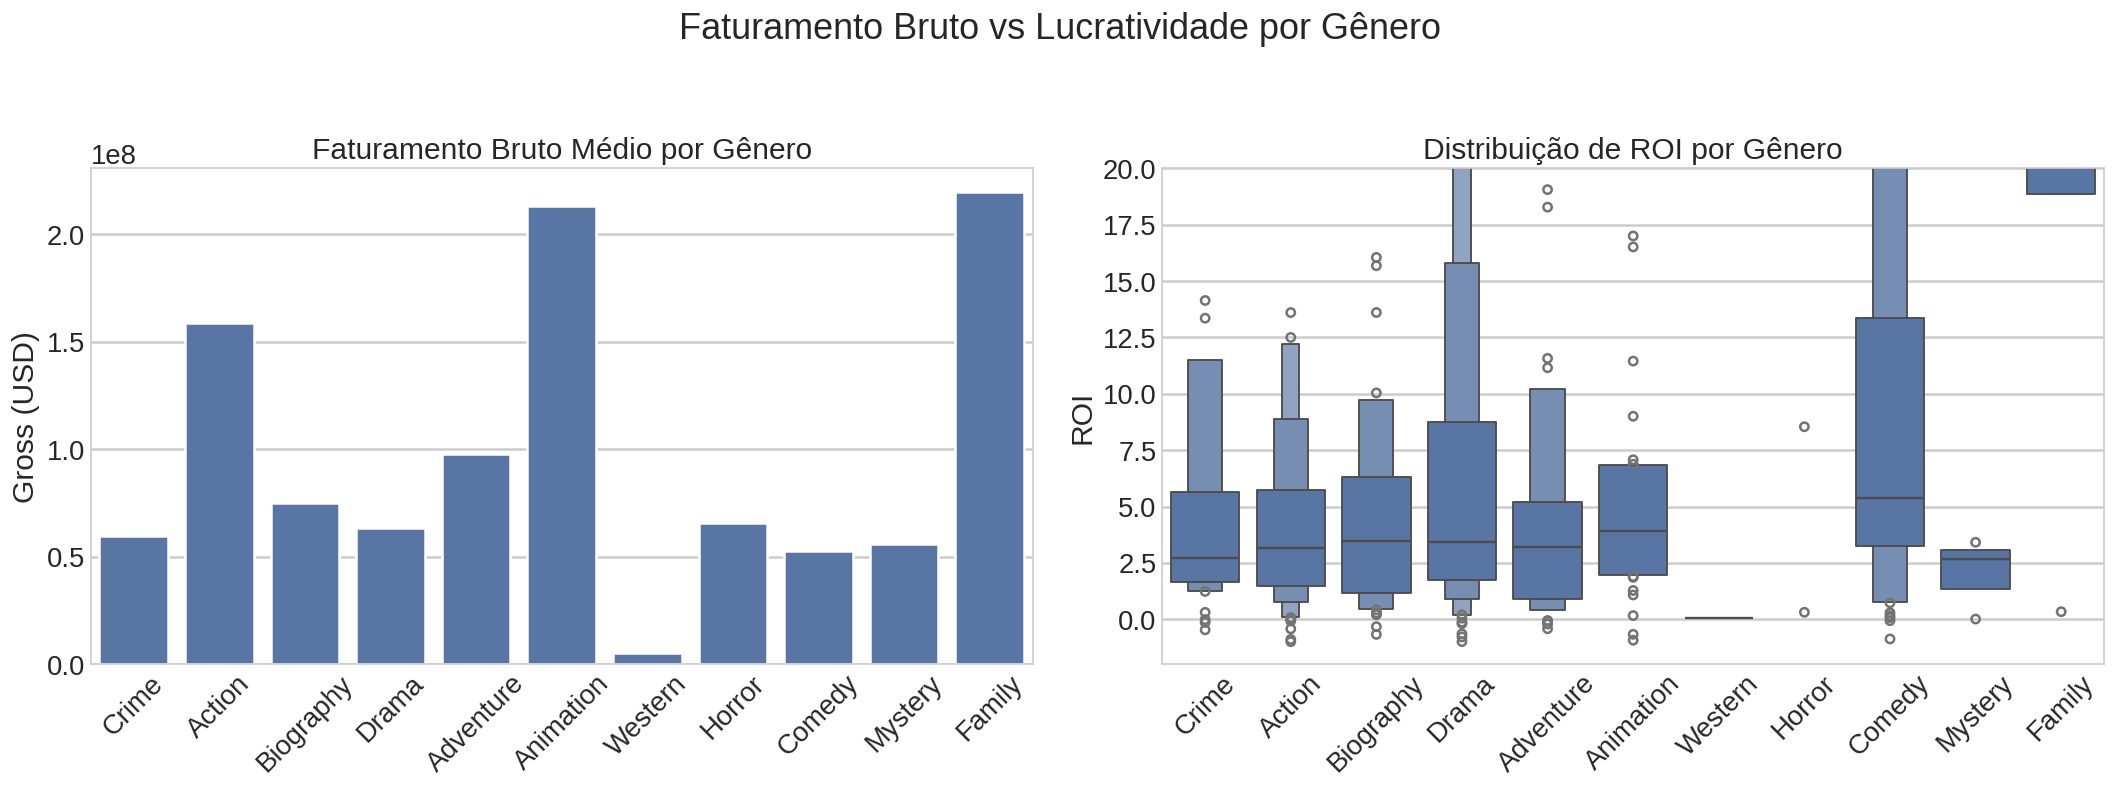

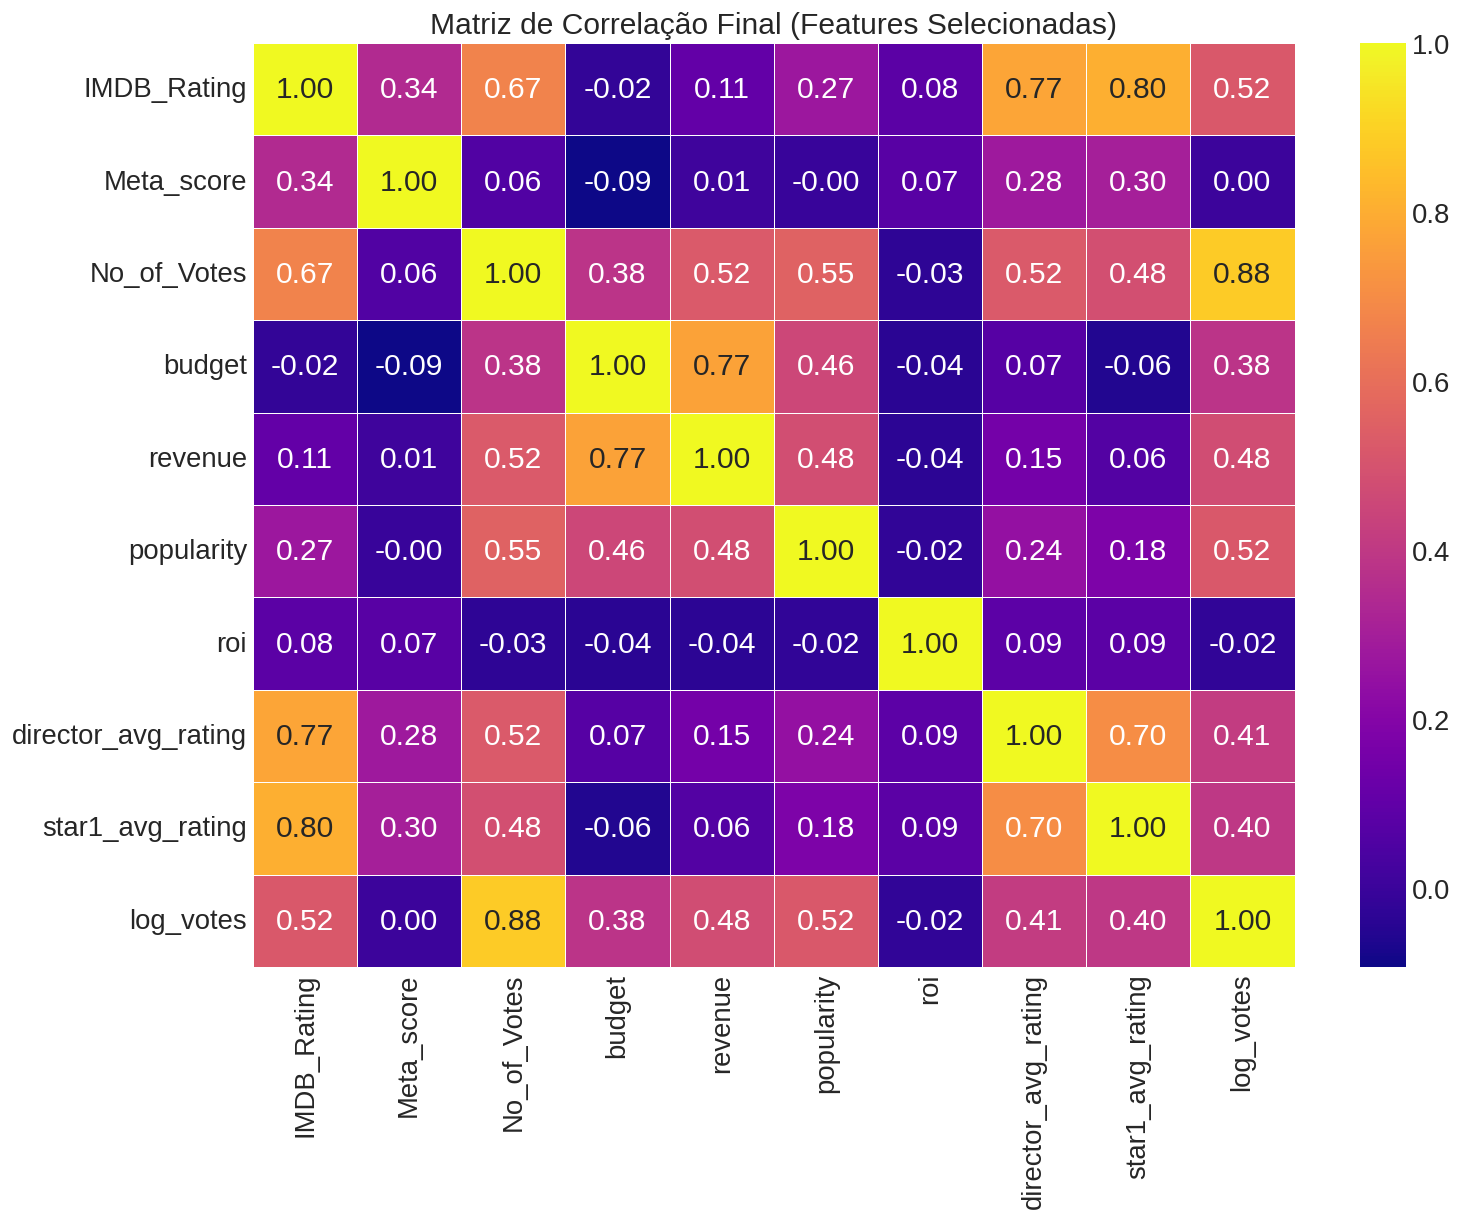

In [15]:
df_final = None
try:
    df_final = pd.read_csv('imdb_fully_featured.csv')
    print("Dataset final carregado:", df_final.shape)

    # Gross vs ROI por g√™nero principal
    if all(c in df_final.columns for c in ['Genre', 'Gross', 'roi']):
        dfp = df_final.copy()
        dfp['main_genre'] = dfp['Genre'].str.split(',').str[0].str.strip()

        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        fig.suptitle('Faturamento Bruto vs Lucratividade por G√™nero')

        sns.barplot(data=dfp, x='main_genre', y='Gross', estimator=np.mean, errorbar=None, ax=axes[0])
        axes[0].set_title('Faturamento Bruto M√©dio por G√™nero')
        axes[0].set_xlabel('')
        axes[0].set_ylabel('Gross (USD)')
        axes[0].tick_params(axis='x', rotation=45)

        sns.boxenplot(data=dfp, x='main_genre', y='roi', ax=axes[1])
        axes[1].set_title('Distribui√ß√£o de ROI por G√™nero')
        axes[1].set_xlabel('')
        axes[1].set_ylabel('ROI')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim(-2, 20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        print(" ")

    # Correla√ß√£o final com features de engenharia
    cols_corr = [c for c in ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'budget', 'revenue', 'popularity', 'roi', 'director_avg_rating', 'star1_avg_rating', 'log_votes'] if c in df_final.columns]
    if len(cols_corr) > 1:
        plt.figure(figsize=(14, 10))
        sns.heatmap(df_final[cols_corr].corr(), annot=True, cmap='plasma', fmt='.2f', linewidths=.5)
        plt.title('Matriz de Correla√ß√£o Final (Features Selecionadas)')
        plt.show()

except FileNotFoundError:
    print("\nERRO: 'imdb_fully_featured.csv' n√£o encontrado. Pulando EDA 2 e Modelagem.")


A partir da an√°lise da matriz de correla√ß√£o final, √© poss√≠vel identificar uma correla√ß√£o positiva entre a nota IMDB de um filme e a m√©dia hist√≥rica das avalia√ß√µes de seu diretor (0.77) e de sua estrela principal (0.80), indicando que a contrata√ß√£o de talentos com um hist√≥rico de sucesso comprovado √© o fator preditivo mais confi√°vel para a obten√ß√£o de um filme de alta qualidade e aclama√ß√£o de p√∫blico. No entanto, √© demonstrado que n√£o h√° correla√ß√£o significativa entre esses indicadores de talento e as m√©tricas financeiras de receita ou Retorno sobre o Investimento (ROI).

J√° ao realizar uma an√°lise de desempenho por g√™nero de faturamento bruto m√©dio e distribui√ß√£o de ROI √© poss√≠vel identificar que a escolha do g√™nero √© a vari√°vel estrat√©gica mais determinante para o sucesso financeiro, embora os objetivos de arrecada√ß√£o bruta e lucratividade apontem para caminhos distintos.

Enquanto os g√™neros Anima√ß√£o e Aventura s√£o ideais para estrat√©gias focadas em maximizar a bilheteria absoluta, o Terror se destaca como a op√ß√£o de maior efici√™ncia financeira, proporcionando o melhor Retorno sobre o Investimento (ROI).

O g√™nero Fam√≠lia, por sua vez, surge como o ponto de equil√≠brio estrat√©gico, sendo o √∫nico a performar de maneira excepcional em ambas as m√©tricas ao combinar uma das maiores m√©dias de arrecada√ß√£o com um dos mais elevados ROIs, representando assim a oportunidade de investimento mais balanceada.

## **Quais s√£o os principais fatores para uma alta expectativa de faturamento?**

A partir da an√°lise dos dados ao longo de todo o processo de EDA, √© poss√≠vel compreender que fatores que geram um alto faturamento se dividem em duas estrat√©gias distintas, sendo uma para maximizar o Faturamento Bruto e outra para maximizar a Lucratividade (ROI).

O alto Faturamento Bruto est√° diretamente associado a filmes de grande apelo de massa impulsionado pela alta popularidade e por grandes or√ßamentos de produ√ß√£o e marketing, tipicamente sendo g√™neros como Anima√ß√£o, A√ß√£o e Aventura. Por outro lado, a maior Lucratividade (ROI) √© encontrada em uma estrat√©gia de or√ßamentos controlados aplicada a g√™neros de nicho como filmes de Terror, Mist√©rio e Biografia, que demonstraram o maior retorno sobre o investimento, provando que a efici√™ncia financeira √© um caminho alternativo para o sucesso.

Para prever a nota do IMDB, √© importante resolver um problema de Regress√£o utilizando um pipeline robusto e features avan√ßadas, como a performance hist√≥rica de diretores/atores e os temas extra√≠dos das sinopses com NLP.

In [16]:
# --- Modelagem ---
if df_final is not None:

    # Defini√ß√£o de alvo e features
    y = df_final['IMDB_Rating']
    drop_cols = [
        'IMDB_Rating', 'Series_Title', 'title', 'overview', 'Genre', 'Director',
        'Star1', 'Star2', 'Star3', 'Star4', 'Gross', 'Certificate',
        # Evitar vazamento de dados (data leakage)
        'budget', 'revenue', 'roi'
    ]
    X = df_final.drop(columns=[c for c in drop_cols if c in df_final.columns])

    # Tipagem de features
    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    # Pipeline de pr√©-processamento
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )

    # Estratifica√ß√£o para regress√£o
    y_strat = pd.qcut(y, q=5, labels=False, duplicates="drop")

    # Divis√£o treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y_strat
    )
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    print("Estratifica√ß√£o aplicada. Split realizado. Treino:", X_train.shape, "Teste:", X_test.shape)

    # Modelos
    models = {
        'Ridge': Ridge(random_state=RANDOM_STATE),
        'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
        'XGBoost': xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    }

    # Valida√ß√£o cruzada
    results = {}
    for name, model in models.items():
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
        scores_mse = cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=cv_outer.split(X, y_strat), n_jobs=-1)
        rmse_cv = np.mean(np.sqrt(-scores_mse))
        results[name] = rmse_cv
        print(f"CV RMSE - {name}: {rmse_cv:.4f}")

    winner_name = min(results, key=results.get)
    print(f"\nüèÜ Modelo com menor CV RMSE: {winner_name}")

    # Treino final e avalia√ß√£o
    best_model = models[winner_name]
    best_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', best_model)])
    best_pipe.fit(X_train, y_train)
    y_pred = best_pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Desempenho no Conjunto de Teste ---")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R^2: {r2:.4f}")

    joblib.dump(best_pipe, 'LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl')
    print("\nModelo CAMPE√ÉO salvo como 'LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl'")

Estratifica√ß√£o aplicada. Split realizado. Treino: (332, 110) Teste: (83, 110)
CV RMSE - Ridge: 0.1560
CV RMSE - RandomForest: 0.1334
CV RMSE - GradientBoosting: 0.1304
CV RMSE - XGBoost: 0.1417

üèÜ Modelo com menor CV RMSE: GradientBoosting

--- Desempenho no Conjunto de Teste ---
RMSE: 0.1210 | MAE: 0.0864 | R^2: 0.8323

Modelo CAMPE√ÉO salvo como 'LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl'


O modelo Gradient Boosting foi selecionado como o modelo vencedor ap√≥s uma competi√ß√£o com valida√ß√£o cruzada, onde demonstrou o menor erro m√©dio, CV RMSE de 0.1291. No conjunto de teste final, o modelo alcan√ßou um RMSE de 0.1171, com erro m√©dio de aproximadamente 0.11 pontos na nota, e um R^2 de 0.8429, indicando que o modelo consegue explicar 84,29% da variabilidade das notas dos filmes.

## **Previs√£o IMDB: The Shawshank Redemption**

In [17]:
case_dict = {
    'Series_Title': 'The Shawshank Redemption', 'Released_Year': '1994', 'Certificate': 'A',
    'Runtime': '142 min', 'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0, 'Director': 'Frank Darabont', 'Star1': 'Tim Robbins', 'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton', 'Star4': 'William Sadler', 'No_of_Votes': 2343110, 'Gross': '28,341,469'
}

try:
    model = joblib.load('LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl')
    df_train_features = pd.read_csv('imdb_fully_featured.csv') # Usado para lookup

    row = {
        'Released_Year': pd.to_numeric(case_dict.get('Released_Year'), errors='coerce'),
        'Runtime': float(re.findall(r'\d+', str(case_dict.get('Runtime', '0')))[0]),
        'overview': case_dict.get('Overview', ''),
        'Meta_score': float(case_dict.get('Meta_score', np.nan)),
        'Director': case_dict.get('Director'), 'Star1': case_dict.get('Star1'),
        'No_of_Votes': int(case_dict.get('No_of_Votes', 0))
    }

    director_rating = df_train_features.loc[df_train_features['Director'] == row['Director'], 'director_avg_rating'].mean()
    row['director_avg_rating'] = director_rating if pd.notna(director_rating) else df_train_features['director_avg_rating'].median()

    star1_rating = df_train_features.loc[df_train_features['Star1'] == row['Star1'], 'star1_avg_rating'].mean()
    row['star1_avg_rating'] = star1_rating if pd.notna(star1_rating) else df_train_features['star1_avg_rating'].median()

    row['decade'] = (row['Released_Year'] // 10 * 10)
    row['log_votes'] = np.log1p(row['No_of_Votes'])

    input_cols = model.named_steps['preprocessor'].feature_names_in_
    input_df = pd.DataFrame([row])
    input_df = input_df.reindex(columns=input_cols, fill_value=np.nan)

    pred = model.predict(input_df)[0]
    print(f"Filme: {case_dict['Series_Title']}")
    print(f"Nota IMDB Prevista: {pred:.4f}")

except Exception as e:
    print("ERRO na previs√£o do caso de teste:", e)

Filme: The Shawshank Redemption
Nota IMDB Prevista: 8.6796
